# Comparison of a Vanilla CNN and RNN on MNIST 
January 29, 2018

The following code implements a recurrent CNN and compares it to a standard lenet-like CNN on the MNIST dataset.

There are three sets: a small 10K train for quick testing, a larger 50K train, and a 10K validation set.
The data is numpy arrays that can be loaded with np.load()
train_images_10K.npy contains 16x64x3 uint8 images
train_labels_10K.npy contains variable length strings corresponding to the label for each image
There are at most 4 digits in this dataset.

In [189]:
# import statements 
from __future__ import print_function
import numpy as np
import time
from tabulate import tabulate

np.random.seed(8998)  # for reproducibility
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Permute
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
from keras.utils import np_utils
from keras import backend as K

from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

import matplotlib.pyplot as plt
%matplotlib inline

# Read in MNIST training data
The code below reads in the training data and reshapes it to match the input for the convolutional and recurrent networks. The MNIST dataset has 60,000 training and 10,000 testing images of 28 by 28 images of digits 0-9 (10 classes). 

In [133]:
# read in mnist data
nb_classes = 10; # 10 classes in mnist
side       = 28;

(X_train_raw, y_train_raw), (X_test_raw, y_test_raw) = mnist.load_data()

#basic image processing
X_train_raw = X_train_raw.astype('float32')
X_test_raw  = X_test_raw.astype('float32')
X_train_raw /= 255
X_test_raw  /= 255

print('X_train_raw shape:', X_train_raw.shape)
print(X_train_raw.shape[0], 'train samples')
print(X_test_raw.shape[0], 'test samples')

X_train_raw shape: (60000, 28, 28)
60000 train samples
10000 test samples


In [134]:
# prepare data for CRNN model 
def transform_for_rnn(X, Y, side):
    examplesPer = X.shape[0]
    maxToAdd    = 1;    
    numToAdd    = 1;

    X_train     = np.zeros((examplesPer,maxToAdd,1,side,side))
    y_train       = []
    for i in range(0,examplesPer):
        #initialize a training example
        output      = np.zeros((maxToAdd,1,side,side))
        indices     = [i]#np.random.choice(X.shape[0],size=numToAdd)
        example     = X[indices]

        exampleY    = Y[indices]
        output[0:numToAdd,0,:,:] = example
        X_train[i,:,:,:,:] = output
        y_train.append(Y[indices]);

    # squeeze out the extra dimension 
    y_train     = np.array(y_train)
    y_train     = y_train.squeeze()
    return X_train, y_train

# prepare data for cnn network
def transform_for_cnn(X, side):
    if K.image_dim_ordering() == 'th':           # this is the version used for testing 
        X = X.reshape(X.shape[0], 1, side, side)
        input_shape = (1, side, side)
    else:
        X = X.reshape(X.shape[0], side, side, 1)
        input_shape = (side, side, 1)
    return X, input_shape

In [6]:
# transform mnist data to categorical variables and make it compatible with network inputs

# convert class vectors to binary classification vectors (for model 1)
Y_train_categorical = np_utils.to_categorical(y_train_raw, nb_classes)
Y_test_categorical = np_utils.to_categorical(y_test_raw, nb_classes)

# pad for RNN
X_train_rnn, Y_train_rnn = transform_for_rnn(X_train_raw, Y_train_categorical, side)
X_test_rnn, Y_test_rnn = transform_for_rnn(X_test_raw, Y_test_categorical, side)

# transform for CNN
X_train_cnn,input_shape = transform_for_cnn(X_train_raw, side);
X_test_cnn,dummy = transform_for_cnn(X_test_raw, side);

We next design and describe two network architectures that we compare in the parameter savings experiment. We compare two types of networks: CNN and RNN (referred to as CRNN/RCNN). Both types of networks have similar layer structure. However, the RNN network has an LSTM layer as the second to last layer and a fully connected layer as the last layer, while the CNN network has two fully connected top layers. 

To investigate any performance changes that the LSTM layer has on the network, we vary the number of outputs in the second to layer on both networks, and compare the effect on the testing accuracy.

Both networks are compared with the same network-level hyperparameters.

In [150]:
# set hyperparameters for all networks that we will be comparing
batch_size = 10;
nb_epochs  = 1;

## Recurrent CNN Model

We next describe the architecture of the recurrent CNN network. We use the time distributed convolutional layer that processes each slice temporally: 

In [160]:
# LSTM Model 
# based on https://github.com/jamesmf/mnistCRNN/blob/master/scripts/addMNISTrnn.py
model_crnn1 = Sequential()
model_crnn1.add(TimeDistributed(Convolution2D(1, 4, 4, border_mode='valid'), input_shape=(1,1,side,side)))
model_crnn1.add(Activation('relu'))

model_crnn1.add(TimeDistributed(Convolution2D(16, 3, 3, border_mode='valid')))
model_crnn1.add(Activation('relu'))

model_crnn1.add(TimeDistributed(Flatten()))
model_crnn1.add(Activation('relu'))
model_crnn1.add(LSTM(output_dim=50,return_sequences=False))
model_crnn1.add(Activation('relu'))

model_crnn1.add(Dense(10))
model_crnn1.add(Activation('relu'))

#model_crnn1.add(LSTM(output_dim=10,return_sequences=False))
model_crnn1.add(Activation('softmax'))
model_crnn1.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])
model_crnn1.summary()

# get number of parameters
nb_params_crnn1 = model_crnn1.count_params()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
timedistributed_291 (TimeDistribu(None, 1, 1, 25, 25)  17          timedistributed_input_98[0][0]   
____________________________________________________________________________________________________
activation_802 (Activation)      (None, 1, 1, 25, 25)  0           timedistributed_291[0][0]        
____________________________________________________________________________________________________
timedistributed_292 (TimeDistribu(None, 1, 16, 23, 23) 160         activation_802[0][0]             
____________________________________________________________________________________________________
activation_803 (Activation)      (None, 1, 16, 23, 23) 0           timedistributed_292[0][0]        
___________________________________________________________________________________________

We can visualize the network as a graph:

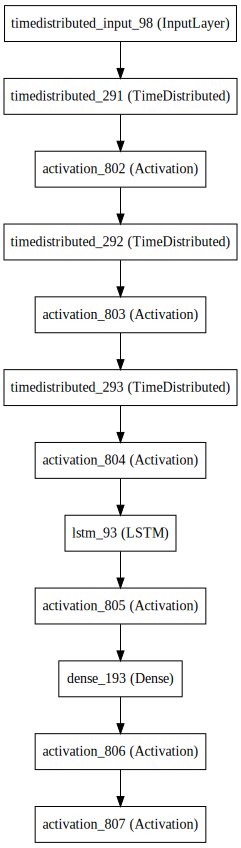

In [161]:
# visualize recurrent model as a graph
SVG(model_to_dot(model_crnn1).create(prog='dot', format='svg'))

We can also train the model as follows:

In [154]:
# train LSTM recurrent model 
history_crnn1 = model_crnn1.fit(X_train_rnn, Y_train_rnn, batch_size=batch_size, nb_epoch=nb_epochs,
          verbose=1, validation_data=(X_test_rnn, Y_test_rnn))

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 312s - loss: 0.3407 - acc: 0.9177 - val_loss: 0.1827 - val_acc: 0.9517


## CNN Model

The plain CNN model has the same number of parameters in the convolutional layers as the recurrent model, but contains a fully connected layer instead of the LSTM recurrent layer, and thus has a different total number of parameters to learn:

In [162]:
# based on https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py   
model_cnn = Sequential()
model_cnn.add(Convolution2D(1, 4, 4,
                        border_mode='valid',
                        input_shape=(1,side,side)))
model_cnn.add(Activation('relu'))

model_cnn.add(Convolution2D(16, 3,3))
model_cnn.add(Activation('relu'))

model_cnn.add(Flatten())
#model_cnn.add(Activation('relu'))

model_cnn.add(Dense(50))
model_cnn.add(Activation('relu'))


model_cnn.add(Dense(10))
model_cnn.add(Activation('relu'))

model_cnn.add(Activation('softmax'))

model_cnn.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])
model_cnn.summary()

# get number of parameters
nb_params_cnn = model_cnn.count_params()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_304 (Convolution2D)(None, 1, 25, 25)     17          convolution2d_input_52[0][0]     
____________________________________________________________________________________________________
activation_808 (Activation)      (None, 1, 25, 25)     0           convolution2d_304[0][0]          
____________________________________________________________________________________________________
convolution2d_305 (Convolution2D)(None, 16, 23, 23)    160         activation_808[0][0]             
____________________________________________________________________________________________________
activation_809 (Activation)      (None, 16, 23, 23)    0           convolution2d_305[0][0]          
___________________________________________________________________________________________

We can visualize the network as a graph:

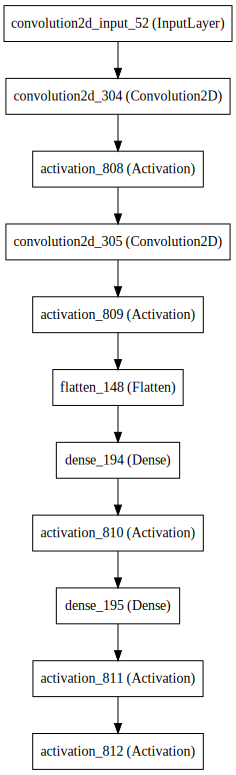

In [163]:
# visualize recurrent model as a graph
SVG(model_to_dot(model_cnn).create(prog='dot', format='svg'))

And we can train the network as follows:

In [164]:
# train CNN model 
history_cnn = model_cnn.fit(X_train_cnn, Y_train_categorical, batch_size=batch_size, nb_epoch=nb_epochs,
          verbose=1, validation_data=(X_test_cnn, Y_test_categorical))

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 66s - loss: 0.2590 - acc: 0.9233 - val_loss: 0.1482 - val_acc: 0.9551


## Parameter Comparisons

We next evaluate the effect of the quantity of parameters on the model accuracy. We first generate the given models with diffent numbers of neurons in the second to last layers of both network types:

In [165]:
# get validation accuracy and # of paramters by varying # of neurons in the second to last layer in the rnn and cnn layers
l_nb_neurons = [10, 50, 100, 150, 200, 250, 300]
def get_rnn_models(l_nb_neurons):
    models = []
    for n_neurons in l_nb_neurons:
        model_crnn = Sequential()
        model_crnn.add(TimeDistributed(Convolution2D(1, 4, 4, border_mode='valid'), input_shape=(1,1,side,side)))
        model_crnn.add(Activation('relu'))

        model_crnn.add(TimeDistributed(Convolution2D(16, 3, 3, border_mode='valid')))
        model_crnn.add(Activation('relu'))

        model_crnn.add(TimeDistributed(Flatten()))
        model_crnn.add(Activation('relu'))
        model_crnn.add(LSTM(output_dim=n_neurons,return_sequences=False))
        model_crnn.add(Activation('relu'))

        model_crnn.add(Dense(10))
        model_crnn.add(Activation('relu'))

        model_crnn.add(Activation('softmax'))
        model_crnn.compile(loss='categorical_crossentropy',
                      optimizer='adadelta',
                      metrics=['accuracy'])
        models.append(model_crnn)
    return models

def get_cnn_models(l_nb_neurons):
    models = []
    for n_neurons in l_nb_neurons:
        model_cnn = Sequential()
        model_cnn.add(Convolution2D(1, 4, 4,
                                border_mode='valid',
                                input_shape=(1,side,side)))
        model_cnn.add(Activation('relu'))

        model_cnn.add(Convolution2D(16, 3,3))
        model_cnn.add(Activation('relu'))

        model_cnn.add(Flatten())

        model_cnn.add(Dense(n_neurons))
        model_cnn.add(Activation('relu'))


        model_cnn.add(Dense(10))
        model_cnn.add(Activation('relu'))

        model_cnn.add(Activation('softmax'))

        model_cnn.compile(loss='categorical_crossentropy',
                      optimizer='adadelta',
                      metrics=['accuracy'])
        models.append(model_cnn)
    return models

# generate models 
models_rnn = get_rnn_models(l_nb_neurons)
models_cnn = get_cnn_models(l_nb_neurons)
l_params_rnn = []
l_params_cnn = []
for (n_neurons, model_rnn, model_cnn) in zip(l_nb_neurons, models_rnn, models_cnn):
    nb_params_rnn = model_rnn.count_params()
    nb_params_cnn = model_cnn.count_params()
    print(n_neurons, nb_params_rnn, nb_params_cnn)
    l_params_rnn.append(nb_params_rnn)
    l_params_cnn.append(nb_params_cnn)   

10 339287 84937
50 1703687 423937
100 3427187 847687
150 5170687 1271437
200 6934187 1695187
250 8717687 2118937
300 10521187 2542687


Below we first look at how the total number of parameters varies as the number of outputs in the second to last layer in the network varies. Each dot in the plot below is a model. The total number of parameters in the RNN increases much faster than the the number of parameters in the CNN which suggests that it is a good idea to consider having a smaller number of neurons in the LSTM layer compared to if a standard CNN were used.  

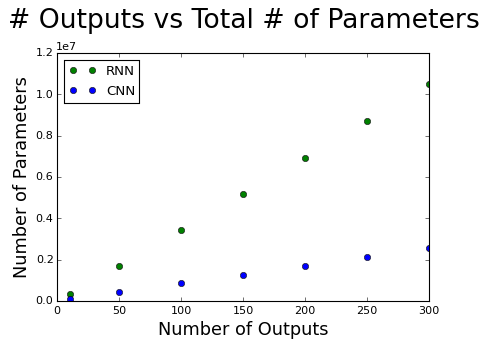

In [166]:
rnn_line, = plt.plot(l_nb_neurons, l_params_rnn, 'go', label = 'RNN')
cnn_line, = plt.plot(l_nb_neurons, l_params_cnn, 'bo', label = 'CNN')

plt.ylabel(r'Number of Parameters', size =16)
plt.xlabel(r'Number of Outputs', size =16)
plt.title(r'# Outputs vs Total # of Parameters', size =24, y=1.08)

plt.legend(handles=[rnn_line, cnn_line],loc=2)
plt.show()

However, what we are really interested in is how the validation accuracy varies as the number of parameters in each type of model is increased. We hence evaluate each of the models above on the dataset and compute the testing accuracy.

We consider only a handful of models of each type to reduce the computation time:

In [168]:
# l_nb_neurons = [10, 50, 100, 150, 200, 250, 300]

# evaluate the models
histories_cnn = []
model_index_cnn = [2,3,4]
for model_index in range(0,len(model_index_cnn)):
    model_cnn = models_cnn[model_index_cnn[model_index]]
    print('Evaluating Model %i out of %i' % (model_index+1, len(model_index_cnn)))
    # train CNN model 
    history_cnn = model_cnn.fit(X_train_cnn, Y_train_categorical, batch_size=batch_size, nb_epoch=nb_epochs,
              verbose=0, validation_data=(X_test_cnn, Y_test_categorical))
    time.sleep(0.1)
    histories_cnn.append(history_cnn)

Evaluating Model 1 out of 3
Evaluating Model 2 out of 3
Evaluating Model 3 out of 3


In [169]:
# evaluate the models
histories_rnn = []
model_index_rnn = [0,1,2]
for model_index in range(0,len(model_index_rnn)):
    model_rnn = models_rnn[model_index_rnn[model_index]]
    print('Evaluating Model %i out of %i' % (model_index+1, len(model_index_cnn)))
    # train RNN model 
    history_rnn = model_rnn.fit(X_train_rnn, Y_train_rnn, batch_size=batch_size, nb_epoch=nb_epochs,
              verbose=0, validation_data=(X_train_rnn, Y_train_rnn))
    time.sleep(0.1)
    histories_rnn.append(history_rnn)

Evaluating Model 1 out of 3
Evaluating Model 2 out of 3
Evaluating Model 3 out of 3


Now we can visualize results by plotting the number of parameters vs validation accuracy in the CNN and CRNN networks.

In [177]:
def get_parameter_and_validation_data(models, histories):
    data = []
    for index in range(0,len(histories)):
        model = models[index];
        history = histories[index];

        val_acc      = history.history['val_acc'][-1]
        training_acc = history.history['acc'][-1]

        nb_params = model.count_params()
        data.append((nb_params, val_acc,training_acc))
    data = np.array(data)
    return data # return validation accuracy (col 0) and number of parameters (col 1)

cnn_data = get_parameter_and_validation_data(models_cnn, histories_cnn)    
rcnn_data = get_parameter_and_validation_data(models_rnn, histories_rnn)


Interestingly, the validation accuracies seem to be better than the training accuracies:

#### CNN Accuracies

In [183]:
print(tabulate(cnn_data,headers=['Number of Parameters', 'Validation Accuracy', 'Training Accuracy']))

  Number of Parameters    Validation Accuracy    Training Accuracy
----------------------  ---------------------  -------------------
                 84937                 0.0966             0.1052
                423937                 0.7917             0.646583
                847687                 0.9743             0.935533


#### RNN Accuracies

In [184]:
print(tabulate(rcnn_data,headers=['Number of Parameters', 'Validation Accuracy', 'Training Accuracy']))

  Number of Parameters    Validation Accuracy    Training Accuracy
----------------------  ---------------------  -------------------
      339287                         0.832267             0.7546
           1.70369e+06               0.9616               0.914817
           3.42719e+06               0.863617             0.831667


We can also plot the above data. The plot below shows the testing accuracy as the number of parameters in each of the CNN and RNN models varies. 

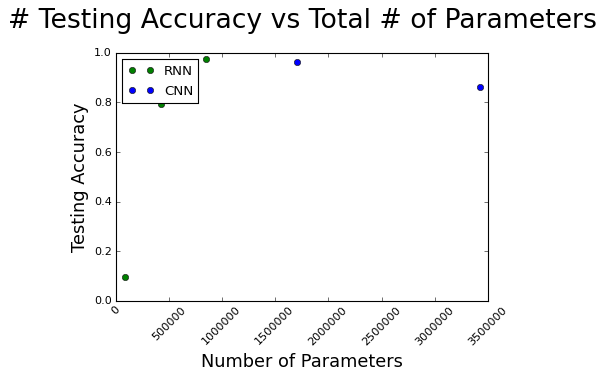

In [185]:
# plot results testing accuracy
rnn_line, = plt.plot(cnn_data[:,0], cnn_data[:,1], 'go', label = 'RNN')
cnn_line, = plt.plot(rcnn_data[:,0], rcnn_data[:,1], 'bo', label = 'CNN')

plt.xlabel(r'Number of Parameters', size =16)
plt.ylabel(r'Testing Accuracy', size =16)
plt.title(r'# Testing Accuracy vs Total # of Parameters', size =24, y=1.08)
plt.xticks(rotation = 45)

plt.legend(handles=[rnn_line, cnn_line],loc=2)
plt.show()

While a more thorough experiment is needed to find the relationship between number of parameters and the quality of prediction, the above experiment suggests that the recurrent CNN network may outperform the standard CNN network in some cases.  

In [186]:
np.savetxt(sys.stdout, rcnn_data, '%5.2f')

339287.00  0.83  0.75
1703687.00  0.96  0.91
3427187.00  0.86  0.83


In [187]:
np.savetxt(sys.stdout, cnn_data, '%5.2f')

84937.00  0.10  0.11
423937.00  0.79  0.65
847687.00  0.97  0.94


In [188]:
# References
# https://github.com/jamesmf/mnistCRNN/blob/master/scripts/addMNISTrnn.py
# https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py    